# Figure 2

This notebook looks at the change in location estiamtes of a specified node as branch lengths are changed within a small handbuilt ARG. Locations are estimated using the sparg approach, individual trees, and an averaging-up approach similar to that from Wohns et al. 2022.

In [3]:
import sparg
import tskit
import numpy as np
import warnings
import matplotlib.pyplot as plt

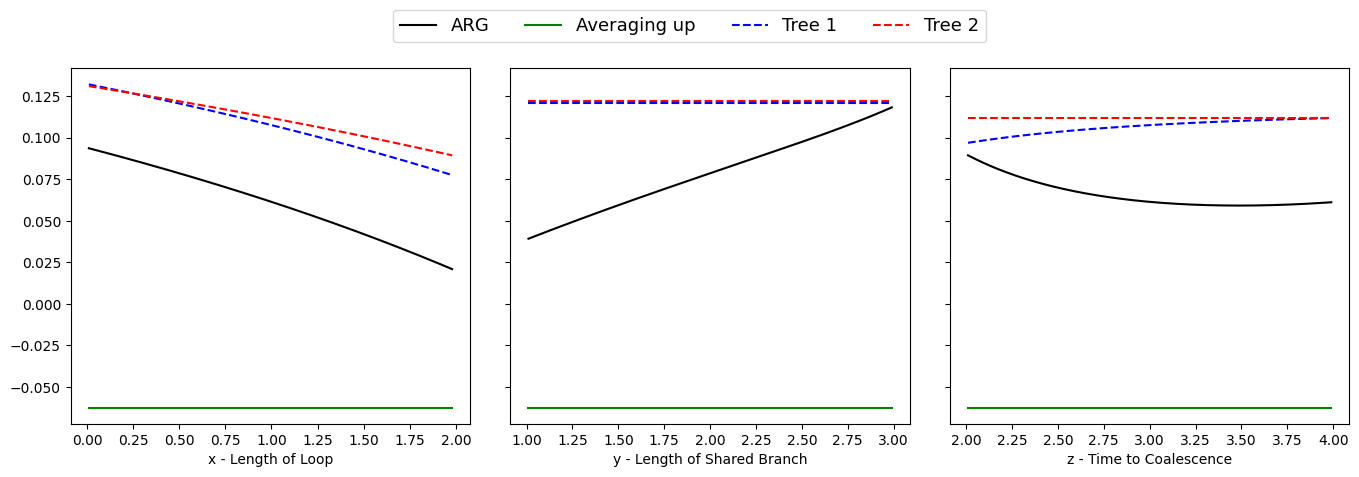

In [6]:
def locate_nodes(nodes, SpARG):
    """Calculate the location of the list of nodes

    Parameters
    ----------
    nodes : list
        List of nodes for which the locations will be calculated
    SpARG : SpatialARG
    	An instance of the SpatialARG class defined below. 

    Returns
    -------
    node_locations : dict
        The keys are the nodes. The values are the geographic location of the nodes in n dimensions
    variance_in_node_locations : dict
        The keys are the nodes. The values are the variance in the geographic location of the nodes in n dimensions
    """

    sigma = SpARG.dispersal_rate_matrix
    paths = SpARG.paths
    inverted_cov_mat = SpARG.inverted_paths_shared_time_matrix
    sample_locs_to_root_locs = SpARG.path_dispersal_distances
    root_locations = SpARG.root_locations
    node_shared_times = SpARG.node_paths_shared_times
    node_paths = SpARG.node_paths
    ts = SpARG.ts
    
    location_of_nodes = {} 
    variance_in_node_locations = {} 
    
    for i,node in enumerate(nodes): 
        node_specific_sharing = node_shared_times[node,:].copy()
        matmul_prod = np.matmul(node_specific_sharing, inverted_cov_mat)
        root_location = root_locations[node_paths[node][-1]]
        node_location = root_location + np.matmul(matmul_prod, sample_locs_to_root_locs)
        location_of_nodes[node] = node_location
        
        base_variance = np.matmul(matmul_prod, np.transpose(node_specific_sharing))
        ones = np.ones(inverted_cov_mat.shape[0])
        correction_denominator = np.matmul(np.matmul(np.transpose(ones),inverted_cov_mat),ones)
        correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
        corrected_variance_scaling_factor = (ts.max_root_time-ts.node(node).time)-base_variance+(correction_numerator/correction_denominator)
        total_variance_node = sigma*corrected_variance_scaling_factor
        variance_in_node_locations[node] = total_variance_node
    return location_of_nodes, variance_in_node_locations


def ts_singlecompound_4sam(x=1, y=2, z=3, n=4, t=5, loc = [-0.5,0,0.5,1] ):     
    ts_singlecompound_4sam = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_singlecompound_4sam.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 1,1, 0, 131072, 131072, 0, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, 0.0, 0.0, x ,y, y, z, n, t]),
        individual = np.array(list(range(4)) + [-1,-1,-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_singlecompound_4sam.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0,0,0], dtype = np.uint32),
        location = np.array(loc),
        location_offset = np.array([0,1,2,3,4], dtype = np.uint64) 
    )
    
    edge_table = ts_singlecompound_4sam.edges
    edge_table.set_columns(
        left=np.array([0.0, 0.0, 5e2, 0.0, 0.0, 5e2, 0, 0, 0, 0]),
        right=np.array([1e3, 1e3, 1e3, 5e2, 1e3, 1e3, 5e2, 1e3, 1e3, 1e3]),
        parent=np.array([4, 4, 5, 6, 7, 8, 7, 8, 9, 9 ], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 1, 4, 4, 2, 5, 6, 7, 3, 8 ], dtype=np.int32),  # References IDs in the node table
    )
    ts_singlecompound_4sam.sort()
    return ts_singlecompound_4sam.tree_sequence()

def Tree_estimates(ts): 
    # S = [ i for i,row in enumerate(ts.tables.nodes) if row.flags == 1 ] 
    S = list(ts.samples())
    breakpoints = list(ts.breakpoints())
    # print(breakpoints)
    n_breakpoints = len(breakpoints)
    mu_list = [] 
    sigma_list = []
    for i in range(n_breakpoints -1):  
        tree = ts.keep_intervals( np.array([[breakpoints[i],breakpoints[i+1]]]), simplify=False) 
        tree = tree.rtrim()
        treeARG = sparg.SpatialARG(ts=tree, dimensions=1)
        sigma = ARG.dispersal_rate_matrix
        loc_nodes, var_nodes = locate_nodes([8],treeARG)
        mu_list += [ loc_nodes[8][0] ]
        sigma_list += [sigma[0][0]]
        
    return mu_list, sigma_list 

def Wilder_Wohns_mu(ts, node, weighted = True): 
    S = [ i for i,row in enumerate(ts.tables.nodes) if row.flags == 1 ] 
    loc = {i:ts.individuals()[i].location[0] for i in S} 
    time = {nd.id:nd.time for nd in ts.nodes() }
    for nd in ts.nodes(): 
        if nd.flags == 1 : 
            continue
        children = ts.tables.edges.child[np.where(ts.tables.edges.parent == nd.id)]
        for child in children:
            if time[child] == time[nd.id]: 
                raise TypeError('Error',nd,child,time[child],time[nd.id])
        wghts = [1 for child in children]
        if weighted: 
            wghts =  [ 1.0/(time[nd.id] - time[child]) for child in children ]
            time[nd.id] -= 1.0/sum(wghts) 
        loc[nd.id] = np.average( [ loc[child] for child in children ] , weights = wghts)
    GMRCA = max( ts.nodes(), key = lambda nd : nd.id ) 
    return loc[node]


midpoint = -0.25
deviation = 0.25
loc3 = 0.5 
loc4 = 0.15

%matplotlib inline

loc = [midpoint - deviation, midpoint + deviation, loc3,loc4]
x_range = np.arange(0.01,1.99,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for x in x_range: 
    ts = ts_singlecompound_4sam(x=x,loc=loc)
    # print(x)1
    ARG = sparg.SpatialARG(ts = ts, dimensions = 1)
    loc_nodes, var_node = locate_nodes([8],ARG)
    mu_fullARG += [ loc_nodes[8][0] ]
    sigma_fullARG += [ ARG.dispersal_rate_matrix[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, node=8, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts, node=8) ]

fig, ax = plt.subplots(1,3,sharey=True,gridspec_kw={'wspace':0.1,'top':0.9,'width_ratios': [13,13,13]}, figsize=(16.5,4.5)) 
ax[0].plot(x_range, mu_fullARG, label = 'ARG', color = 'black') 
ax[0].plot(x_range, mu_wohns, label = 'Averaging up', color = 'green') 
#ax[0][1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[0].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

ax[0].set_xlabel('x - Length of Loop', fontsize = 10) 
#ax[0].set_ylabel('Location of the MRCA', fontsize = 10)
""" ---------------- """
y_range = np.arange(1.01,2.99,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for y in y_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_singlecompound_4sam(x=0.5, y=y,loc=loc)
    ARG = sparg.SpatialARG(ts=ts, dimensions=1)
    loc_nodes, var_node = locate_nodes([8],ARG)
    mu_fullARG += [ loc_nodes[8][0] ]
    sigma_fullARG += [ ARG.dispersal_rate_matrix[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, node=8, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts, node=8) ]

ax[1].plot(y_range, mu_fullARG, label = 'ARG', color = 'black') 
ax[1].plot(y_range, mu_wohns, label = 'Averaging up', color = 'green') 
#ax[1][1].plot(y_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[1].plot(y_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])


ax[1].set_xlabel('y - Length of Shared Branch', fontsize = 10) 
#ax[1].set_ylabel('Location of the MRCA', fontsize = 10)
""" ---------------- """
z_range = np.arange(2.01,3.99,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for z in z_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_singlecompound_4sam(z=z,loc=loc)
    ARG = sparg.SpatialARG(ts=ts, dimensions=1)
    loc_nodes, var_node = locate_nodes([8],ARG)
    mu_fullARG += [ loc_nodes[8][0] ]
    sigma_fullARG += [ ARG.dispersal_rate_matrix[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, node=8, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts, node=8) ]

ax[2].plot(z_range, mu_fullARG, label = 'ARG', color = 'black') 
ax[2].plot(z_range, mu_wohns, label = 'Averaging up', color = 'green') 
#ax[2][1].plot(z_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[2].plot(z_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize = 13, ncol = 4)

ax[2].set_xlabel('z - Time to Coalescence', fontsize = 10)

plt.show()